# Advanced Business Analytics - Technical Report
##  Engagement Prediction of News Articles on Facebook

11 May 2022 

Welcome to the technical report of the project: Engagement Prediction of News Articles on Facebook. This project is made by the following students: <br>
Hans Christian Bechsøfft Mikkelsen, s184294 <br>
Marie Sjørslev Pedersen, s174329 <br>
Martin Illum, s184286 <br>
Oliver Svane Olsen, s184294

**Table of contents:**
1. Introduction
2. Data cleaning & Exploratory Analysis
3. Topic Modelling
4. Google Trends
5. Deep-learning
6. Discussion
7. Conclusions

## Introduciton

![alt text](Data/cover_pic.jpg "Title")

<a class="anchor" id="first-bullet"></a>
The impact social media platforms have had on the distribution of articles from news outlets has been significant. About half of U.S. adults (53%) say they get news from social media “often” or “sometimes,” and this use is spread out across a number of different sites, according to a Pew Research Center survey conducted Aug. 31-Sept. 7, 2020. Among 11 social media sites asked about as a regular source of news, Facebook sits at the top, with about a third (36%) of Americans getting news there regularly. But what articles a shown to which users?[1]

The facebook algorithm has long been a hot topic what news feed is shown to you. The specific details of how it works is not known, however there are supposedly three main ranking parameters.
* 1. Who posted it? Content by people or business affilated with you will be priotized.
* 2. The type of content, if you a more prone to click on videos, videos will be shown to you.
* 3. Interaction with the post, feed will prioritize posts with a lot of engagement, especially from people you interact with a lot.[2]

So when an article is shown to the user, a long process has been gone through to pick that exact one. But what determines whether the user will enteract with the article? Is it the cover picture, title, news oulet or a combination of all?

This notebook will try to explore what is important for news articles on Facebook, in order for people to enteract with them. This can be usefull for editors of newspaper to ensure that the articles they choose to share, are the one who will gain the most traction.

 This project will build a model to predict the user engangment, with a special focus on article headlines, the cover picture or the news outlet. In order to achieve this several methods has been used: web-scraping, top-modelling, deep learning.

### Data Sources

 The main data file for this project is obtained from https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement, and webscrapes & API usuage has been carried out to supplement the data set.
In this project three data sources are used.

- A data set containing 10437 rows representing unique articles from September 2019 to October 2019. The data set contain 15 columns where 11 of the are information about the article and the 4 of the are metrics on different engangement type with the article.

## Data Cleaning & Exploratory Analysis


First of all we will load all packages used in this notebook:

In [1]:
# Basic
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import os
import PIL
import glob
import warnings
import itertools

# Visualizations 
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
from PIL import Image

# Topic Modelling
# !pip install bertopic
from bertopic import BERTopic
import re, nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from typing import List

# Web Scrapping
# !pip install pytrends
import requests
from pytrends.request import TrendReq
pytrends = TrendReq()
from bs4 import BeautifulSoup
import time
df=pd.read_csv("Data/articles_data.csv")

A quick overview of the data

In [2]:
df.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


### Basic exploration of the data

This data exploration will main revovle around the article data set, where each row represents an unique article. In the output below an overview of the columns and their data type can be seen. Most of the columns are rather self-explainatory. However, a few require further elaboration:
* "Content" - which only contains the first 250 characters in each article

* "top_article" - a binary column indicating if article was listed as a top article on publisher website

* "engagement_reaction_count" - Users reactions count for posts on Facebook involving article URL

* "engagement_comment_count" - Users comments count for posts on Facebook involving article URL

* "engagement_share_count" - Users shares count for posts on Facebook involving article URL

* "engagement_comment_plugin_count" - Users comments count for Facebook comment plugin on article website

We take a quick look at the data types, there are multiple categorical values, while all engagement metrics are in float.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10437 non-null  int64  
 1   source_id                        10437 non-null  object 
 2   source_name                      10437 non-null  object 
 3   author                           9417 non-null   object 
 4   title                            10435 non-null  object 
 5   description                      10413 non-null  object 
 6   url                              10436 non-null  object 
 7   url_to_image                     9781 non-null   object 
 8   published_at                     10436 non-null  object 
 9   content                          9145 non-null   object 
 10  top_article                      10435 non-null  float64
 11  engagement_reaction_count        10319 non-null  float64
 12  engagement_comment

A further look into the data shows that there a missing values in most of the columns.

In [4]:
NA = pd.DataFrame(data=[df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
            columns=df.columns, index=['NA Count', 'NA Percent']).T.\
            sort_values(by='NA Count',ascending =False)
NA.style.background_gradient(cmap="summer", subset=['NA Count'])
#Code inspired from https://www.kaggle.com/code/kingabzpro/internet-news-and-consumer-engagement

,NA Count,NA Percent
content,1292,12.38%
author,1020,9.77%
url_to_image,656,6.29%
engagement_reaction_count,118,1.13%
engagement_comment_count,118,1.13%
engagement_share_count,118,1.13%
engagement_comment_plugin_count,118,1.13%
description,24,0.23%
title,2,0.02%
top_article,2,0.02%


However we have 10000 unique articles, so for the sake of having clean data data we are dropping the rows with missing NA values as well as the column "Unnamed" which is identical to the index

In [5]:
df = df.dropna(subset = [ 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'published_at',
       'top_article', 'engagement_reaction_count', 'engagement_comment_count',
       'engagement_share_count', 'engagement_comment_plugin_count', 'content'])
df=df.drop(columns=["Unnamed: 0"])

We will change the publishing date to date time for later:

In [6]:
warnings.filterwarnings("ignore")
df.published_at = pd.to_datetime(df.published_at)

df['Day_Of_Week'] = df.published_at.apply(lambda x: x.dayofweek)
df['Month'] = df.published_at.apply(lambda x: x.month)
df['Year'] = df.published_at.apply(lambda x: x.year)
df['date'] = df.published_at.dt.strftime('%Y-%m')

Lets have a quick look at the number of articles published each day, here we can also see that our data spans from Start september to mid october, roughly 1.5 month which is that big a time interval.

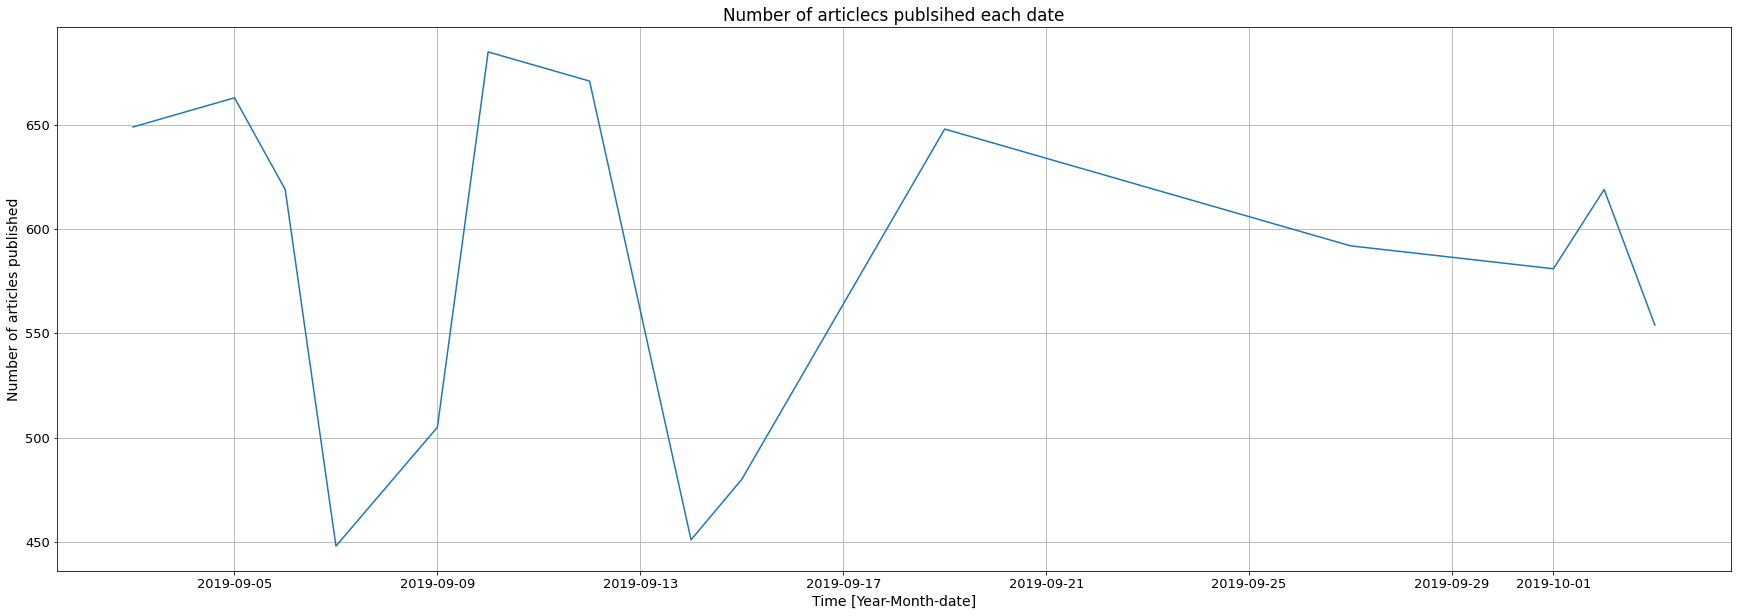

In [7]:
plt.rcParams.update({'font.size': 14})
df.published_at.dt.date.value_counts().plot(figsize=(30,10),
                                            xlabel="Time [Year-Month-date]",
                                            ylabel="Number of articles published",
                                            fontsize=13,
                                            title="Number of articlecs publsihed each date")
plt.grid()

Lets have a look if there is a trend for when articles are published (Local time). Here we can see a quite interesting pattern. As could be assummed very few articles are published at night 24:00 -> 06:00, it could be assummed that a lot of these stories are breaking news from around the world. Then a steady increase of articles published occurs between 06:00 -> 17:00. Intereting enough no articles in our data set is published between 19:00 -> 24:00, which seems very odd. We can see that only a small part of all the articles are top articles, which follows the same distribution as all the articlecs.

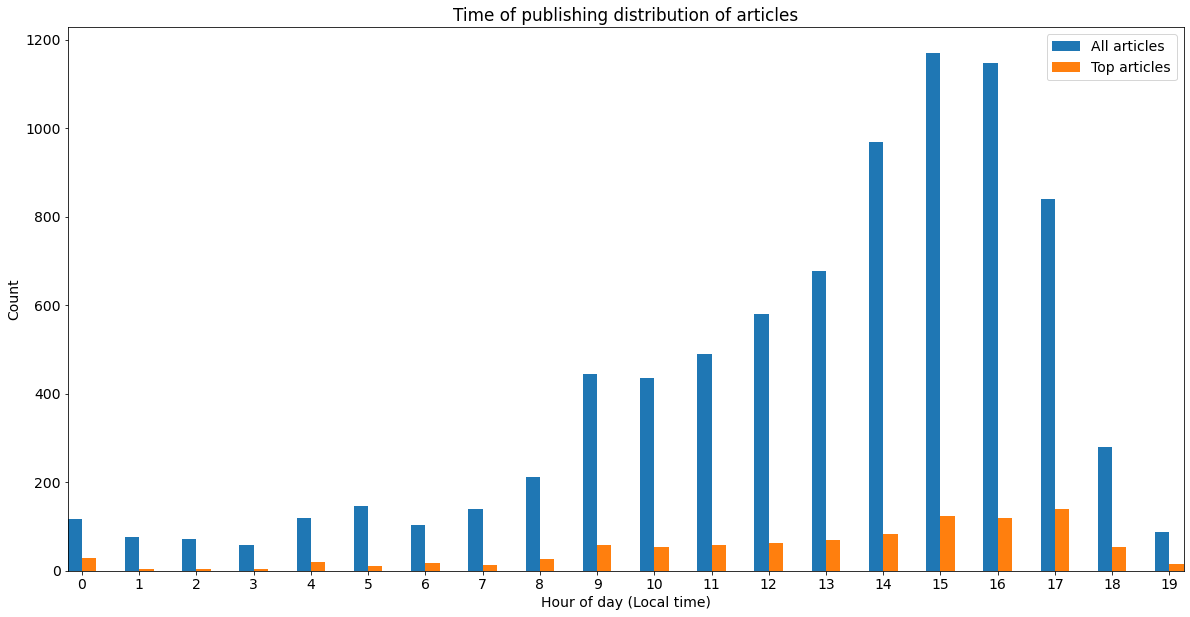

In [8]:
bar_df=df.published_at.dt.hour.value_counts().sort_index().to_frame()
bar_df['Top_article']=df.groupby(df["published_at"].dt.hour)['top_article'].sum().values

_, ax = plt.subplots()
bar_df.plot(
            kind="bar",
            figsize=(20,10),
            title="Time of publishing distribution of articles",
            xlabel="Hour of day (Local time)",
            ylabel="Count",
            rot=0,
            ax=ax,
            legend="Count of all articles");
bar_df.Top_article.plot(
            kind="bar",
            figsize=(20,10),
            title="Time of publishing distribution of articles",
            xlabel="Hour of day (Local time)",
            ylabel="Count",
            rot=0,
            ax=ax,
            color="orange",
            width=0);
ax.legend(["All articles", "Top articles"])

#df.groupby(df["published_at"].dt.hour)['top_article'].count().plot(kind="bar")
#seaborn.countplot(data=df, x='reputation', order=df.reputation.value_counts().index)

Lets explore the data further, here we take a look at the top 15 authors based on number of articles written, and the top Sources based on number of articles published. Its quite clear that the top "top" authors are not individual persons, but articles published in the name of the publisher. There are a few indivduals based on who have written an impressive amount of articles (40-80) in the 1.5 month interval our data spans over.

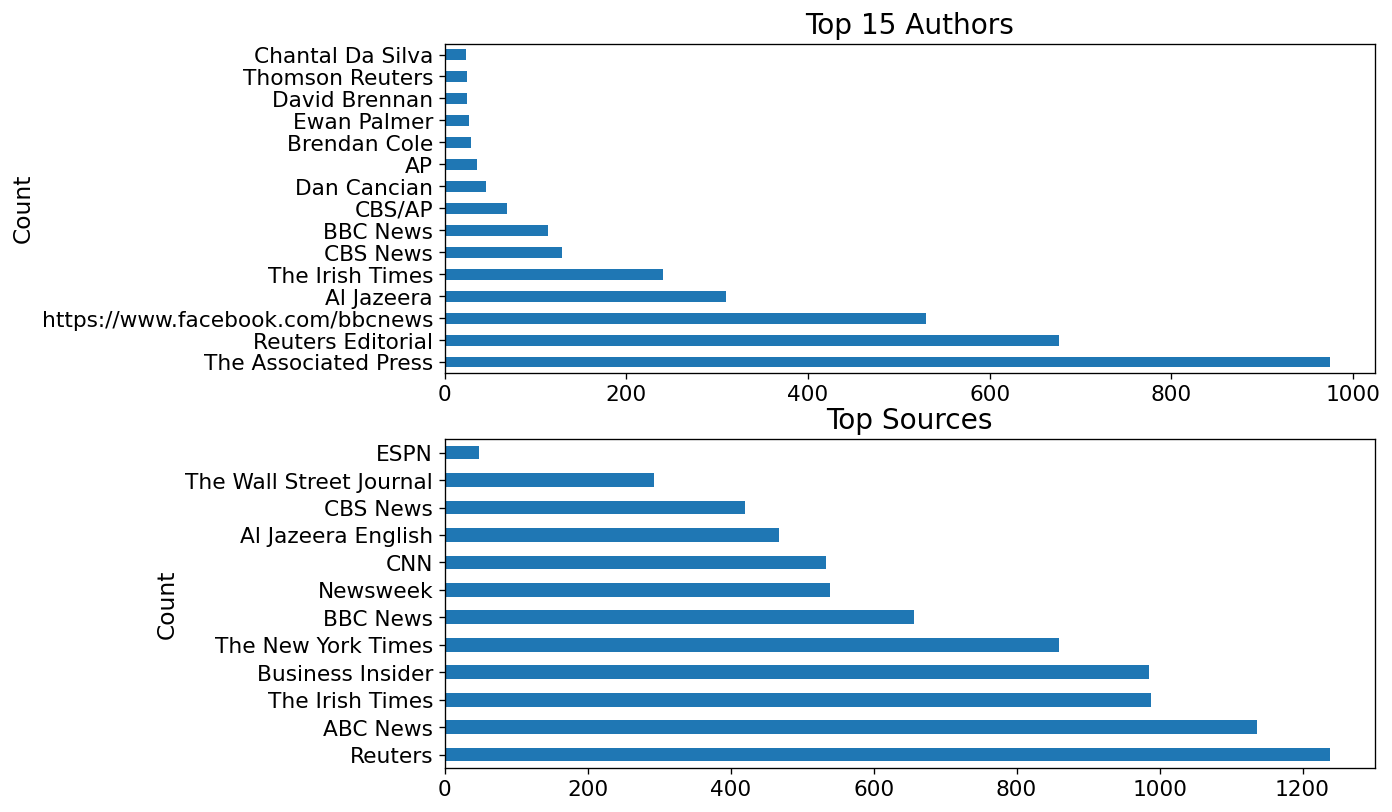

In [9]:
figure, ax = plt.subplots(2, 1,figsize=(10,8),dpi=120) #TODO labels
plt.tight_layout

df['author'].value_counts()[:15].plot(kind='barh',
                                      title="Top 15 Authors"
                                      ,ax=ax[0],
                                      fontsize=13,
                                      xlabel="Count",
                                      ylabel="Author")

df['source_name'].value_counts().plot(kind='barh',
                                      title="Top Sources",
                                      ax=ax[1],
                                      fontsize=13,
                                      xlabel="Count",
                                      ylabel="Publisher")

plt.show()

Finally we have the Facebook metrics for the articles we can a deeper look into. Below is the four different metrics shown with a distribution plot with a (Log/Lin) axis. The first thing that can be seen is there are a lot more different values for the metrics showing "Reaction_count, Comment_count, share_count" compared to "comment_plugin_count_metric". Another intersting thing from the plot is that the majortiy of articles have all most no engangement, all graphs seems to be log normal distributed.

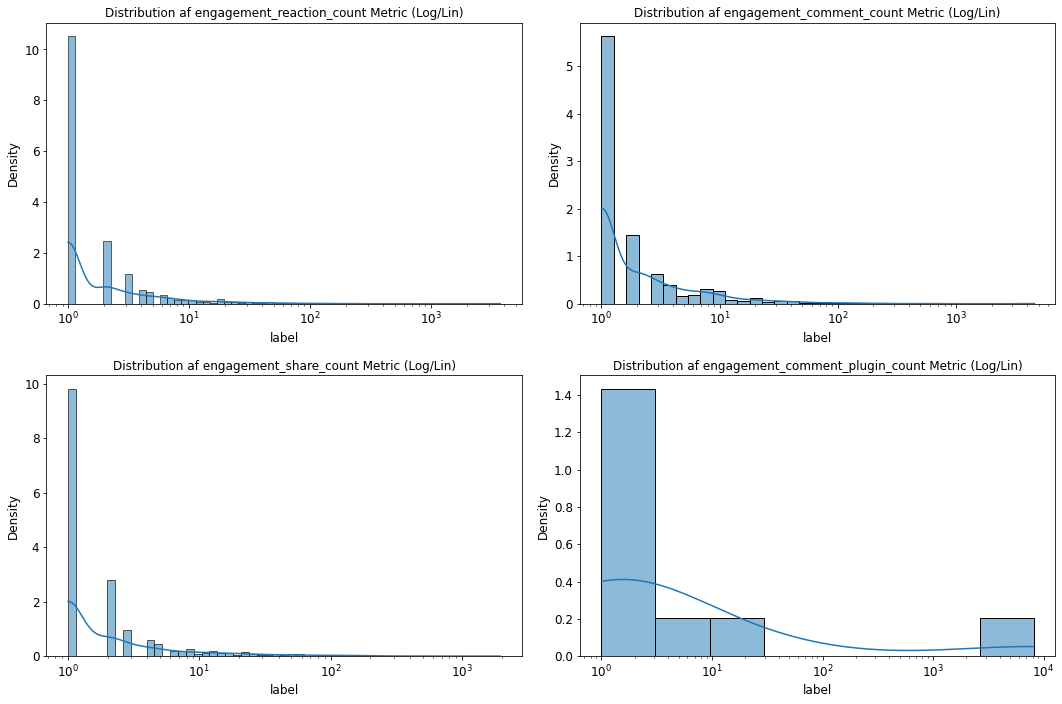

In [10]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
channels=['engagement_reaction_count', 'engagement_comment_count',
       'engagement_share_count', 'engagement_comment_plugin_count']
k=0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].tick_params(labelsize=12)
        ax[j][i].set_xlabel('label', fontsize=12, position=(.5,20))
        ax[j][i].set_ylabel('Density', fontsize=12)
        ax[j][i].set_title(f'Distribution af {channels[k]} Metric (Log/Lin)', size=12)
        ax[j][i].set(xscale="log")
        ax[j][i] = sns.histplot(df[channels[k]].value_counts(), ax=ax[j][i],kde=True, stat="density")
        k+=1

fig.tight_layout()
#plt.savefig("DistKanal.png")

Now that we have gone through the more interesting attributes in the data set, lets have a look how they correlate with eachother.

It can be that there are quite high correlation between all of the metrics but the "Engangement_comment_plug_in". We can also see that there is some correlation between the share_count and whether the article is a top one.

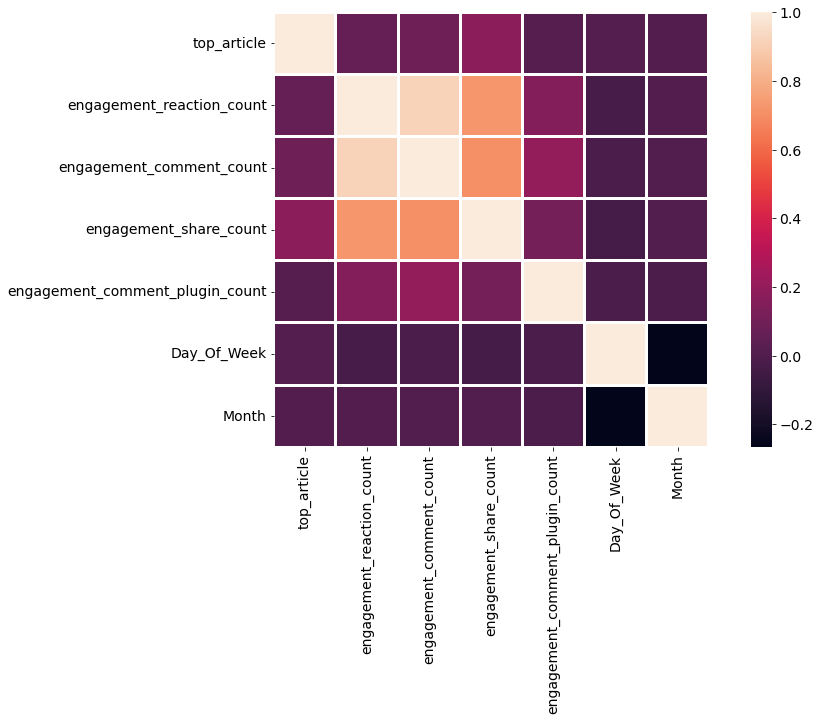

In [11]:
corr=df.drop(columns=["Year"]).corr()
plt.figure(figsize=(15,8))
ax1 = sns.heatmap(corr, linewidths=2, square=True, cmap='rocket')
plt.show()

# Scraping pictures

In our data set we also have a column containing URLS for the cover picture of every article. This could be quite interesting to use in our final prediction model. Therefore we will scarpe all the images we can get a hold of. Scraping pictures from specific URLS are different than pinging a website for different content. 

First we will do some data cleaning in the URLS. After some trial and error we saw specific URLS types which gave a bad respond but could modified.

In [12]:
import re
front="/images/"
front2="/image/"
end="-"
Front_url="https://i.insider.com/"

new_urls=[]

for i in range(len(df)):
    if df.source_id.iloc[i]=="business-insider":
        try:
                if df.iloc[i].url_to_image[0:11]=="https://amp":
                    id_name=re.search(f'{front}(.*)', df.iloc[i].url_to_image.split("-")[0]).group(1)
                    full_url = Front_url+id_name
                    new_urls.append(full_url)

                else:
                    id_name=re.search(f'{front2}(.*)', df.iloc[i].url_to_image.split("-")[0]).group(1)
                    full_url = Front_url+id_name
                    new_urls.append(full_url)
        except:
            new_urls.append(df.iloc[i].url_to_image)
    else: new_urls.append(df.iloc[i].url_to_image)

We then save a list with All the new URLS and their index in the data frame.

In [13]:
df['url_to_image_real']=new_urls
urls=[x for x in df.url_to_image_real]
index=[x for x in df.index]

This function will create a request to the given URL, save the picture as PNG. Then reopen the picture, resize it to a 128*128 shape and finally save it. 

In [14]:
import time
def im_scrape(urls,filename):
    call = requests.get(urls)
    if str(call)=="<Response [200]>":
        img_data = call.content
        with open(f'images/{filename}.png', 'wb') as handler:
             handler.write(img_data)
        #time.sleep(2) 
        image=Image.open(f"images/{filename}.png")
        resized_image = image.resize((128,128))
        resized_image.save(f'images/{filename}.png')
        
    else:
        print(urls)

for i in range(len(urls)): #dont run me :)
    try:
        im_scrape(urls[i],index[i])
    except: #print all failing URLS
        print(urls[i])

Since then plan was to use the images for predictions, all articles withouth an associated image will be removed from our data set. This leaves us with roughly 7500 articles.

from os import listdir
from os.path import isfile, join
mypath="/Users/martinillum/Desktop/Desktop_mac_air/Kandidat/Advanced_business_analytics/Final_project/ABA_2022/Data/images"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
sorted_list = [x.split(".")[0] for x in onlyfiles]
sorted_list = sorted(sorted_list)[1:]
sorted_list = sorted([int(x) for x in sorted_list])
sorted_list = [str(x)+".png" for x in sorted_list]

df = df.loc[sorted_list_number] #TODO fjern udkommentering når vi aflevere
df=df.rename(columns = {df.columns[0]:'Image_path'})
df.to_csv("Data/Final_data_cleaing.csv")

We have now had a look at the categorical columns and float columns. We will therefore have a deeper look at the column "Content" containing a maximum of 250 characters from each article.

## Topic modeling with BERT and text cleaning

The purpose of topic modeling on the dataset is to find keywords/topics for each article to give as input to Google Trends API to get an insight how popular certaint topics were at given timestamp.

For topic modeling `BERTopic` made by Maarten Grootendorst will be used, which is a Bidirectional Encoder Representations from Transformers (BERT) based topic modeling technique [4]. 

The first step of `BERTopic` is converting the documents to numerical data. This is where BERT are used to extract different embeddings based on the context of the word using pretrained language model. The second step is to reduce the dimensionality of the resulting embeddings to optimize the clusteringprocess. `BERTopic` does this with the `UMAP()` algorithm. After having reduced the dimensionality of the documents embeddings, `BERTopic` cluster the documents with `HDBSCAN()`. Lastly, from the clusters of documents,topic representations are extracted using a custom class-based variation of TF-IDF (c-TF-IDF).

`BERTopic` is used because it extracts the different embeddings based on the context of the word, instead of LDA's bag-of-words approach, which is believed to be important when making topics for articles. #TODO Jeg føler vi mangler et 'because'. Den er nice fordi det her med context of words, og det er nice fordi...

First, filter the data from stopwords and then lemmatize it, this will be done with the `nltk` library.

In [9]:
#TODO check if this is not already done
# Drop rows with nan-values in specific columns
df = df.dropna(subset = [ 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'published_at',
       'top_article', 'engagement_reaction_count', 'engagement_comment_count',
       'engagement_share_count', 'engagement_comment_plugin_count', 'content'])
# Reset index
df = df.reset_index(drop=True)

In [10]:
#TODO HC kan du beskrive lidt mere hvad der foregår her? Det ligner bare den samme der sker 3 gange. Hvorfor laver vi to? Hvad gør at titlen skal have dens egen?
#Function for cleaning text
def cleaned_text(text, source_name):
    try:

        if source_name == 'Reuters':
            clean = re.split('-',text,1)[1]
            clean = re.sub("\n"," ",clean)
            clean = clean.lower()
            clean = re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
            clean = re.sub("\[.*?\]", "", clean)
            clean = re.sub("[^a-z]"," ",clean)
            clean = clean.lstrip()
            clean = re.sub("\s{2,}"," ",clean)
            clean = re.sub(r'\b\w\b', '', clean)

        else:
            clean = re.sub("\n"," ",text)
            clean = clean.lower()
            clean = re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
            clean = re.sub("\[.*?\]", "", clean)
            clean = re.sub("[^a-z]"," ",clean)
            clean = clean.lstrip()
            clean = re.sub("\s{2,}"," ",clean)
            clean = re.sub(r'\b\w\b', '', clean)
    except:
        clean = np.nan
    return clean

def cleaned_title(text):
    clean = re.sub("\n"," ",text)
    clean = clean.lower()
    clean = re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean = re.sub("\[.*?\]", "", clean)
    clean = re.sub("[^a-z]"," ",clean)
    clean = clean.lstrip()
    clean = re.sub("\s{2,}"," ",clean)
    clean = re.sub(r'\b\w\b', '', clean)
    
    return clean

In [22]:
# Cleaning text
df["cleaned_content"] = df.apply(lambda x : cleaned_text(x['content'], x['source_name']), axis=1)
df["cleaned_title"] = df.apply(lambda x : cleaned_title(x['title']), axis=1)

# Drop rows with nan in column cleaned_content
#TODO har du ikke allerede fjernet NaN?
df = df.dropna(subset = ['cleaned_content'])
df = df.reset_index(drop=True)

Next, all stopwords are removed. It was found that the word 'say' had a high frequency, whitout giving much information. Thus it was removed along with the stopwords. 

In [23]:
stop = stopwords.words('english')
stop.append("say")
# Remove stopwords
df["stop_removed_content"]=df["cleaned_content"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [24]:
# Tokenize
df["tokenized"]=df["stop_removed_content"].apply(lambda x: nltk.word_tokenize(x))

In [25]:
# Function for lematize
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text

# Lematize
df["lemmatized"] = df["tokenized"].apply(lambda x: word_lemmatizer(x))
df["lemmatize_joined"] = df["lemmatized"].apply(lambda x: ' '.join(x))

An example of the text preprocessing done above can be seen here: 

In [54]:
print("Original text:",df.iloc[3,[8][0]])
print()
print("Cleaned text:",df.iloc[3,[19][0]])

Original text: LONDON (Reuters) - The European Union is waiting to see if British lawmakers block Brexit before giving Britain concessions to strike a new withdrawal agreement, Prime Minister Boris Johnson said. 
Johnson, who has pledged that Britain will leave the EU on O… [+777 chars]

Cleaned text: european union wait see british lawmakers block brexit give britain concessions strike new withdrawal agreement prime minister boris johnson say johnson pledge britain leave eu


Next, the topic will be created with the `BERTopic` library. The pre-trained embedding model named `all-MiniLM-L6-v2` will be used, which is a general purpose model trained on more than 1 billion training pairs. There are many different pre-trained embedding model, which can be found at https://www.sbert.net/docs/pretrained_models.html [5]. `all-MiniLM-L6-v2` is chosen because it has a good trade-off between performance and speed.

In [ ]:
# create model  #TODO skal dette fjernes?

#model = BERTopic(verbose=True, embedding_model = 'all-MiniLM-L6-v2', calculate_probabilities = True, nr_topics="auto")
 
#topics, probabilities = model.fit_transform(df['lemmatize_joined'])

# Save model

#model.save("topics_model")

In [ ]:
# Load model #TODO skal dette fjernes?

model = BERTopic.load("topics_model")

topics, probabilities = model.transform(df['lemmatize_joined'])

Batches:   0%|          | 0/254 [00:00<?, ?it/s]

2022-04-29 13:06:51,624 - BERTopic - Reduced dimensionality with UMAP
2022-04-29 13:06:52,052 - BERTopic - Predicted clusters with HDBSCAN
2022-04-29 13:06:59,596 - BERTopic - Calculated probabilities with HDBSCAN


The model finds 114 topics, where -1 refers to all documents that did not have any topics assigned. So, 2483 articles have not been assigned a topic.

`BERTopic` uses the clustering algorithm `HDBSCAN` [6] and a trait with this algorithm is that it doesn't force all documents/articles towards a certain cluster. If no cluster could be found, then it is simply an outlier.

In [ ]:
print(f'Number of topics the model find: {len(model.get_topic_freq())}')
print(f'Number of articles with an assigned topic: {model.get_topic_freq().Count[1:].sum()}')
model.get_topic_freq()

Number of topics the model find: 114
Number of articles with an assigned topic: 5637


,Topic,Count
0,-1,2483
1,0,453
2,1,386
3,2,345
4,3,306
...,...,...
109,108,11
110,109,11
111,110,10
112,111,10


#TODO HC får lige lov til at omskrive denne sektion :) <br>
We could "force" outlier articles into topics by looking at the probabilities for each article to be in each topic. That way, we can select, for each article, the topic with the the highest probability. Thus, although we do generate an outlier class in our `BERTopic` model, we can assign article to an actual topic. However after testing can we not argument for the trade-off of only lossing 183 outlier articles with an probability of 10%.

In [ ]:
#TODO Skal dette slettes?
probability_threshold = 0.1
new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in probabilities]
# Calculate the number of new articles with topics
model.get_topic_freq().Count[0].sum()-new_topics.count(-1)

Following code chunk makes a visual graph of the 12 largest topics. 

In [1]:
# Defining new visualize_barchart function 
# Modification of code from https://github.com/MaartenGr/BERTopic/blob/master/bertopic/plotting/_barchart.py
def visualize_barchart2(topic_model,
                       topics: List[int] = None,
                       top_n_topics: int = 12,
                       n_words: int = 5,
                       width: int = 250,
                       height: int = 250) -> go.Figure:
    colors = itertools.cycle(["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"])

    # Select topics based on top_n and topics args
    if topics is not None:
        topics = list(topics)
    elif top_n_topics is not None:
        topics = topic_model.get_topic_freq().Topic.to_list()[1:top_n_topics + 1]
    else:
        topics = topic_model.get_topic_freq().Topic.to_list()[1:7]

    # Initialize figure
    subplot_titles = [f"Topic {topic}" for topic in topics]
    columns = 4
    rows = int(np.ceil(len(topics) / columns))
    fig = make_subplots(rows=rows,
                        cols=columns,
                        shared_xaxes=False,
                        x_title = 'c-TF-IDF score',
                        y_title = 'top 5 words',
                        horizontal_spacing=.1,
                        vertical_spacing=.4 / rows if rows > 1 else 0,
                        subplot_titles=subplot_titles)

    # Add barchart for each topic
    row = 1
    column = 1
    for topic in topics:
        words = [word + "  " for word, _ in topic_model.get_topic(topic)][:n_words][::-1]
        scores = [score for _, score in topic_model.get_topic(topic)][:n_words][::-1]

        fig.add_trace(
            go.Bar(x=scores,
                   y=words,
                   orientation='h',
                   marker_color=next(colors)),
            row=row, col=column)

        if column == columns:
            column = 1
            row += 1
        else:
            column += 1

    # Stylize graph
    fig.update_layout(
        template="plotly_white",
        showlegend=False,
        title={
            'text': "<b>Topic Word Scores",
            'x': .5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width=width*4,
        height=height*rows if rows > 1 else height * 1.3,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
    )
    
    
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)
    
    return fig

NameError: name 'List' is not defined

In [ ]:
visualize_barchart2(model)

Looking at the 12 largest topics, some patterns can be detected. Topic 0 is about Donald Trump and topic 7 is about the protest in Hong Kong. However, there are also topics which is not as clear and well defined as those two. Topic 10 top 3 words are 'food', 'li' and 'restaurant' which doesn't give a clear picture of an event at a given moment.

As mentioned in the beginning of this section, the purpose of the topic modelling is to generate three topics which can be used in Google Trend API in order to tell whether a topic is relevant or not for the time of relase.

In [ ]:
# Making topic column
df['Topic'] = topics

def get_3_topic(data, model):
    topic1 = []
    topic2 = []
    topic3 = []
    
    for i in data:
        if i < 0:
            topic1.append(np.nan)
            topic2.append(np.nan)
            topic3.append(np.nan)
        else:
            topic1.append(model.get_topic(i)[0][0])
            topic2.append(model.get_topic(i)[1][0])
            topic3.append(model.get_topic(i)[2][0])

    return topic1, topic2, topic3

In [ ]:
topic1, topic2, topic3 = get_3_topic(df['Topic'], model)

df['Topic1'] = topic1
df['Topic2'] = topic2
df['Topic3'] = topic3

In [ ]:
#TODO check at dette virker!
print("Original text:",df.iloc[3,[8][0]])
print()
print("Topic 1, 2 and 3:",df.iloc[3,[21,22,23][0]])

### Partial conclusion

It could be seen that method has generated some good topics for 5637 of the articles. However, there are still 2483 articles which was not assigned topics, which is not ideal when we need to model and therefore we need to assign a value for the articles without assigned keywords. And we saw that forcing articles into topics didn't give big enough gain.

Another problem with our approach of assigning 3 keywords based on the 3 top words of the assigned article, is that for some topics is the words c-TF-IDF score significant different. For instance, is topic 11 word "school" c-TF-IDF double as large as the other two words (students, parents). Compared to topic 1 words, which have almost the same c-TF-IDF score. This will our model not know and therefore will there be some uncertainty in our data.

A third problem is with the automatisation of assigning the keywords for each article. If we look at the description for article "North Korean footballer Han joins Italian giants Juventus" and its assigned keywords, can we see that it is about football, which the keywords refers to. However, the football player does not join Real Madrid, which the third keyword refers to, but Juventus.

In [ ]:
print(df['title'][2])
print(df[['Topic1','Topic2', 'Topic3']])

## Google Trend
After the three topics for each article was identied, the goal was to create a metric for how relevant was this topic at the date the article was published? This done under the assumption that people read articles that are relevant for the current time. If the topic is not 'popular' at the time of release, it will not be well resieved by the end-users, hence the user engangement would decrease. <br>
An example of this could be the topic of Covid-19. If you had written and article about Covid-19 back in Febrauary 2020, chanches are that most people would be very interested in that article. Whereas today, nobody wants to read anymore about covid-19.  <br>
This next section will provide each topic with a metric of how relevant this topic is at the time of release. 

In order to determine a topics relevance `pytrend` is used, which is an unofficial API for Google Trends. Google Trend is a great tool for mapping what poeple are seaching for, in real time. 

I order to optimize the computional power the three columns with topics are combined and the `unique()` function is used to find every unique topic. This limits the number of requests made to Google Trends API, seeing that many of the topics are seen in more than one topic column. <br>

`pytrend` is in many ways an easy and great tool, but is comes with many limitations. The timeframe of which a topic is investigates can not surpass more than 10 years from today. Luckily the lastest date in this data set is from September 2019. The date format is also very restrictive, as it only works for each seventh day in the month. A decision was made to shorten the date format, which originaly was in `YYYY-MM-DD` to simply a `YYYY-MM` format. This reduced the number of dates to two dates (2019-09 and 2019-10). That is why the input of the function is only a single date string. <br>

A final remark about the function was that the topic = "date" would not be accepted as input in `pytrends`, which is why it simply was just removed. 

In [ ]:
## September 2019
df_09 = df[df['date']=='2019-09']
topic_09_list = []
topic_09_list.append(df_09['Topic1'].unique())
topic_09_list.append(df_09['Topic2'].unique())
topic_09_list.append(df_09['Topic3'].unique())

topic_09_list = list(itertools.chain.from_iterable(topic_09_list))
topic_09_list = list(set(topic_09_list))
# topic_09_list.remove('date')

## October 2019
df_10 = df[df['date']=='2019-10']
topic_10_list = []
topic_10_list.append(df_10['Topic2'].unique())
topic_10_list.append(df_10['Topic3'].unique())
topic_10_list.append(df_10['Topic1'].unique())

topic_10_list = list(itertools.chain.from_iterable(topic_10_list))
topic_10_list = list(set(topic_10_list))
# topic_10_list.remove('date')

When is comes the actual value returned by API, `pytrends`agian comes with its limitations. According to Lazarina Stoy from October 2021 she says the following about the returned value:

> Values are calculated on a scale from 0 to 100, where 100 is the location with the most popularity as a fraction of total searches in that location, a value of 50 indicates a location that is half as popular, and a value of 0 indicates a location where the term was less than 1% as popular as the peak. (Soruce: https://lazarinastoy.com/the-ultimate-guide-to-pytrends-google-trends-api-with-python/)

The following function looks at a time period from five years ago to today. Depending on the month and year selected it returns a mean value for the topic for that specific month. It is averaged because `pytrends` still returns the every seven day of the month. It is assumed in this project that the interest of a topic is constant throughout a month. 

In [ ]:
def Topic_Value(date,topic):
    # Initialize pytrends API request
    pytrends.build_payload([topic], cat=0, timeframe='today 5-y') 
    data = pytrends.interest_over_time() 
    data = data.reset_index() 
    
    # Group to only see year and month
    data['YearMonth'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m')
    # Average for the enitre month
    data = data.groupby('YearMonth').mean()
    # Find value for topic 
    value = data[topic].filter(items = [date], axis=0)[0]

    # Should be increased if not runned in Google Colab.
    time.sleep(3)
    return value

The next code chunk then takes the list of topics and use the `Topic_Value` function to pull a value and saves it in a list with the coresponding values for that topic. 

In [ ]:
topic_value_oct = []
topic_value_sep = []

# Topics and values from September 2019 
for i in topic_09_list:
  topic_value_sep.append(Topic_Value('2019-09',i))
  # print(i,';', topic_value_sep[-1])

# Topics and values from October 2019 
for i in topic_10_list:
  topic_value_oct.append(Topic_Value('2019-10',i))
  # print(i,';', topic_value_oct[-1])

The next code chunks are made to combine the topic and values for the different timestamps the dataframe.

In [ ]:
df_topics_1 = pd.DataFrame({'date': '2019-09','Topic1': topic_09_list,'Topic 1 Score': topic_value_sep})
df_topics_2 = pd.DataFrame({'date': '2019-09','Topic2': topic_09_list,'Topic 2 Score': topic_value_sep})
df_topics_3 = pd.DataFrame({'date': '2019-09','Topic3': topic_09_list,'Topic 3 Score': topic_value_sep})

df_topics_1_10 = pd.DataFrame({'date': '2019-10','Topic1': topic_10_list,'Topic 1 Score': topic_value_oct})
df_topics_2_10 = pd.DataFrame({'date': '2019-10','Topic2': topic_10_list,'Topic 2 Score': topic_value_oct})
df_topics_3_10 = pd.DataFrame({'date': '2019-10','Topic3': topic_10_list,'Topic 3 Score': topic_value_oct})

df_topics_1 = df_topics_1.append(df_topics_1_10)
df_topics_2 = df_topics_2.append(df_topics_2_10)
df_topics_3 = df_topics_3.append(df_topics_3_10)

df = pd.merge(df, df_topics_1,  how='left', left_on=['date','Topic1'], right_on = ['date','Topic1'])
df = pd.merge(df, df_topics_2,  how='left', left_on=['date','Topic2'], right_on = ['date','Topic2'])
df = pd.merge(df, df_topics_3,  how='left', left_on=['date','Topic3'], right_on = ['date','Topic3'])

## Reflection
A reflection about the Google Trend API is done by firstly interpreting the values given with the `Topic_Value` function.

In [ ]:
print("Google Trend value for the topic 'Brexit' from September 2019:",Topic_Value('2019-09','brexit'))

As mentioned before Google Trend API works by giving a value between 0-100. A value of 37.8 for the topic Brexit is not particulary high. Looking at the graph below which visualizes the interest of the topic Brexit over the last five years, it seems that eventhough brexit might not be the hottest topic it was still very relevant at the time. 

In [ ]:
topic = ['brexit']
pytrends.build_payload(topic, cat=0, timeframe='today 5-y') 
data = pytrends.interest_over_time() 
data = data.reset_index() 
fig = px.line(data, x="date", y=topic[0], title='Brexit Web Search Interest Over Time')
fig.show() 

In [ ]:
print("Google Trend value for the topic 'flight' from September 2019:",Topic_Value('2019-09','flight'))

Looking at the value for the topic 'flight' it is much higher than 'brexit'. Again a visualization of the interest the last five years are displayed below. However, the reason for the high value in the topic is because this topic is always a highly searched topic. The big descrease in searches in march 2010 could to due to Covid-19, that made people unable to travel on vacation or business trips. As Covid-19 is slowly disappear from our lives, the demand the flight increses angain.

In [ ]:
topic = ['flight']
pytrends.build_payload(topic, cat=0, timeframe='today 5-y') 
data = pytrends.interest_over_time() 
data = data.reset_index() 
fig = px.line(data, x="date", y=topic[0], title='Flight Web Search Interest Over Time')
fig.show() 

The two topic examples raises a question about the usefullness of `pytrends`, because the metric suggests, according to our asseumption, that if an author writes an article about 'flight' it will be more relevant than if the person wrote about 'brexit'. `pytrends` or Google Trend does not provide the actual number of seaches for a topic, making it difficult to determine if the number is high because it truely is relevant for the time period or high because the it always a seached topic. However, while Google Trend has many limitations and makes it difficult to compare topic values, it is still included in the project as a way to enrich the data set. This is done because the value given by Google Trend still gives some kind of indication whether the topic is relevant or not. 

A final reflection about Google Trend and possible futher work to be done, would be to look into the sources (news agency). Many of the sources are targeting a specific segment. For instance the The Irish Times would not be relevant for the population of Denmark, but highly relevant for the irish people. `pytrends` has a input field for region specification. This step would make the value given by Google Trend more specific for the chosen region. However the downside of this would be that many sources such like reuters, which is a international news agency, would not be able to be reduced to a single area. 

## Deep Learning & Predictions

## Discussion

## Conclusion

Sources <br>
[1] - https://www.pewresearch.org/journalism/2021/01/12/news-use-across-social-media-platforms-in-2020/ \
[2] - https://blog.hootsuite.com/facebook-algorithm/ \
[3] - https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement  \
[4] - https://github.com/MaartenGr/BERTopic 
[5] - https://www.sbert.net/docs/pretrained_models.html
[6] - https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html 